In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import matplotlib as mpl
from tqdm.notebook import tqdm
from datetime import datetime, date

### Load data

In [2]:
def get_df():
    df = []
    for fname in glob.glob("csse_covid_19_data/csse_covid_19_daily_reports/*.csv"):
        report_date = fname.split("/")[-1].replace(".csv", "")
        _df = pd.read_csv(fname)
        _df["report_date"] = report_date
        _df.columns = [col.replace("/", "_").replace(" ","_") for col in _df.columns]
        df.append(_df)
    df = pd.concat(df)
    df["Last_Update"] = pd.to_datetime(df["Last_Update"])
    df["report_date"] = pd.to_datetime(df["report_date"])
    df["date"] = df["report_date"] # seems to make more sense than the "Last Update"
    df = df.sort_values(by="date")
    df = df.drop_duplicates()
    return df

In [3]:
def merge(df):
    # for merging several countries/regions
    df = df.groupby("date").sum()
    df = df.reset_index()
    return df

df = get_df()
df = df[df["Country_Region"] == "Germany"]
#df = merge(df[df["Country_Region"] == "US"])
#df = merge(df[(df["Country_Region"] == "United Kingdom") | (df["Country_Region"] == "UK")])
#df = merge(df[df["Country_Region"].apply(lambda x : "Korea" in x)])
#df = merge(df[df["Country_Region"].apply(lambda x : "China" in x)])
#df = df[df["Country_Region"] == "Italy"]
#df = df[df["Country_Region"] == "Japan"]
#df = df[df["Country_Region"] == "Belgium"]
#df = df[df["Country_Region"] == "Iran"]
#df = df[df["Country_Region"] == "Spain"]
#df = df[df["Country_Region"] == "France"]; df.Province_State.fillna("France", inplace=True); df = df[df["Province_State"] == "France"]
#df = df[df["Country_Region"] == "Sweden"]
#df = df[df["Country_Region"] == "Poland"]

# optionally resample the hole thing to smooth out the diffs
df = df.set_index("date").resample("3d").last()
df = df.reset_index()

for field in ["Confirmed", "Deaths", "Recovered"]:
    df[f"{field}_diff"] = df[field].diff()
    df[f"{field}_diff"] /= (df.date.astype("int").diff().values / 1e9 / 3600 / 24)
    df[f"{field}_diff_diff"] = df[f"{field}_diff"].diff()

In [4]:
df.drop(
    columns=[
        col
        for col in [
            "Province_State",
            "report_date",
            "Latitude",
            "Longitude",
            "Lat",
            "Long_",
            "FIPS",
            "Admin2",
            "Combined_Key",
            "Active"
        ]
        if col in df
    ]
).tail()

,date,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Confirmed_diff,Confirmed_diff_diff,Deaths_diff,Deaths_diff_diff,Recovered_diff,Recovered_diff_diff
21,2020-03-31,Germany,2020-04-02 23:25:00,84794.0,1107.0,22440.0,5969.666667,631.666667,154.000000,53.000000,2980.000000,699.333333
22,2020-04-03,Germany,2020-04-05 23:06:26,100123.0,1584.0,28700.0,5109.666667,-860.000000,159.000000,5.000000,2086.666667,-893.333333
23,2020-04-06,Germany,2020-04-08 22:51:39,113296.0,2349.0,46300.0,4391.000000,-718.666667,255.000000,96.000000,5866.666667,3780.000000
24,2020-04-09,Germany,2020-04-11 22:45:13,124908.0,2736.0,57400.0,3870.666667,-520.333333,129.000000,-126.000000,3700.000000,-2166.666667
25,2020-04-12,Germany,2020-04-12 23:17:00,127854.0,3022.0,60300.0,982.000000,-2888.666667,95.333333,-33.666667,966.666667,-2733.333333


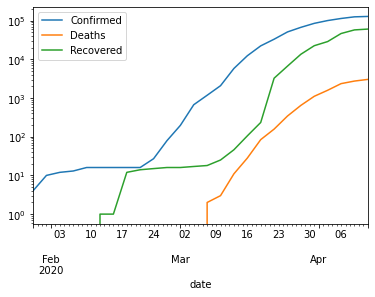

In [5]:
fig, ax = plt.subplots()
df.plot(x="date", y="Confirmed", ax=ax)
df.plot(x="date", y="Deaths", ax=ax)
df.plot(x="date", y="Recovered", ax=ax)
ax.set_yscale("log")

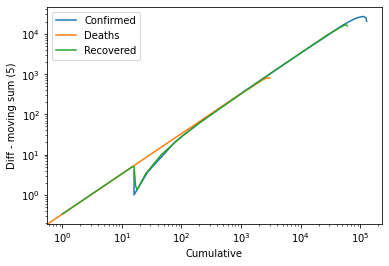

In [6]:
# inspired by https://aatishb.com/covidtrends/
for field in ["Confirmed", "Deaths", "Recovered"]:
    plt.plot(df[field], df[f"{field}_diff"].rolling(5).sum(), label=field)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Diff - moving sum (5)")
plt.xlabel("Cumulative")
plt.legend()

In [7]:
def colorline(x, y, ax, **kwargs):
    from matplotlib.collections import LineCollection
    z = np.linspace(0.0, 1.0, len(x))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, array=z, **kwargs)
    ax.add_collection(lc)
    return lc

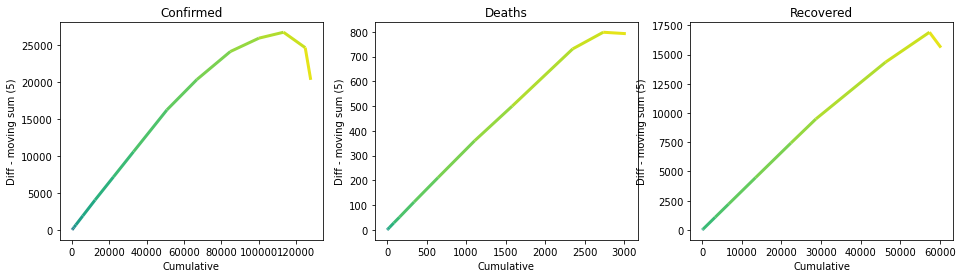

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
for ax, field in zip(axs, ["Confirmed", "Deaths", "Recovered"]):
    colorline(df[field], df[f"{field}_diff"].rolling(5).sum(), ax, linewidth=3)
    ax.autoscale()
    ax.set_title(field)
    ax.set_ylabel("Diff - moving sum (5)")
    ax.set_xlabel("Cumulative")

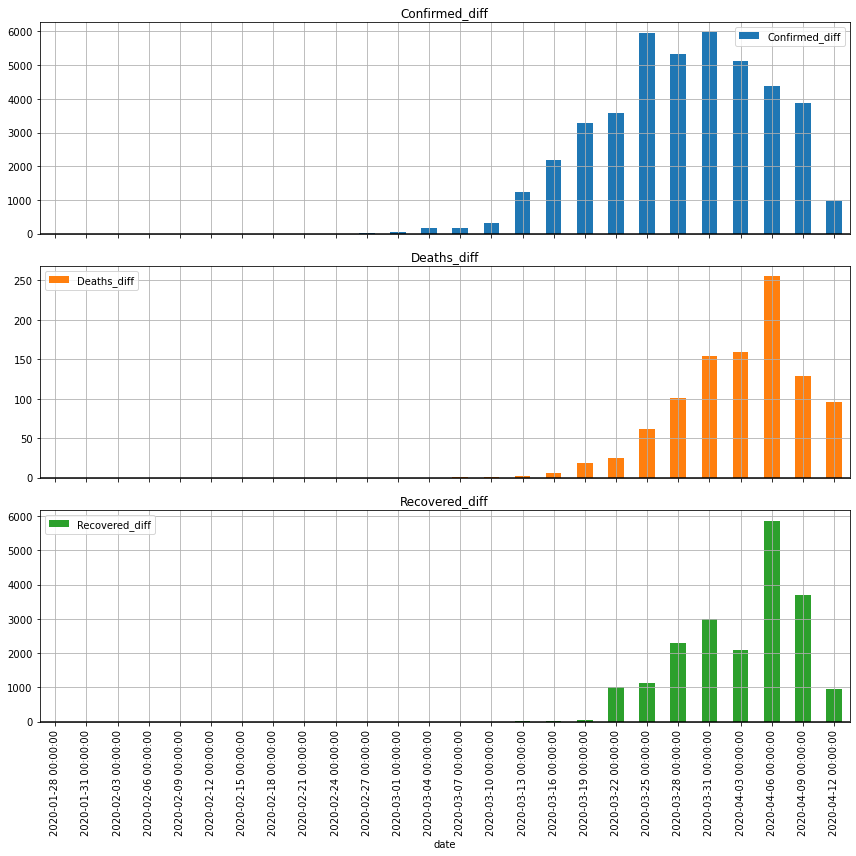

In [9]:
axs = df.iloc[-30:].plot.bar(
    x="date",
    #y=["Confirmed_diff_diff", "Deaths_diff_diff", "Recovered_diff_diff"],
    y=["Confirmed_diff", "Deaths_diff", "Recovered_diff"],
    subplots=True,
    figsize=(12, 12)
)
for ax in axs:
    ax.axhline(0, color="black")
    #ax.set_yscale("symlog")
    ax.grid()
fig = axs[0].get_figure()
fig.tight_layout()
#fig.savefig("diff_diff.pdf")

### Fit exponential

In [10]:
def func(x, a, b, c):
    return a * np.exp(b * (x - c))

In [11]:
def get_xy(df, field="Confirmed"):
    # DataFrame contains cumulative cases (called 'int' here)
    # np.diff gives new confirmed cases per day
    x_int = df.date.astype("int").values
    x_int = (x_int - x_int[0]) / 1e9 / 3600 / 24
    x = x_int
    #y = np.diff(df[field]) / np.diff(x_int)
    #y = np.nan_to_num(y)
    y = df[f"{field}_diff"].fillna(0).values
    y_int = df[field].values
    y_int = np.nan_to_num(y_int)
    
    return x, y, x_int, y_int

Exponential fit for new and cumulative cases per day:

In [12]:
fields = ["Confirmed", "Deaths"]

In [13]:
fit_results_diff = {}
fit_results_int = {}
fit_data = {}
for field in fields:
    fit_data[field] = get_xy(df, field=field)
    x, y, x_int, y_int = fit_data[field]
    est_b_y = np.log(2) / np.count_nonzero(y > y[-1] * 0.5)
    est_b_y_int = np.log(2) / np.count_nonzero(y_int > y_int[-1] * 0.5)
    est_c_y = x[y>0][0]
    est_c_y_int = x_int[y_int>0][0]
    fit_results_diff[field] = scipy.optimize.curve_fit(func, x, y, p0=(1, est_b_y, est_c_y))
    fit_results_int[field] = scipy.optimize.curve_fit(func, x_int, y_int, p0=(1, est_b_y_int, est_c_y_int))

<ipython-input-10-54abd0354d15>:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(b * (x - c))


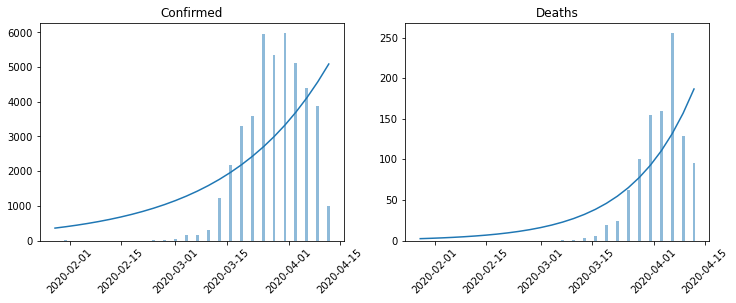

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
for ax, field in zip(axs, fields):
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]
    ax.bar(df["date"], y, alpha=0.5)
    ax.plot(df["date"], func(x, *popt))
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)

Plot both new and cumulative

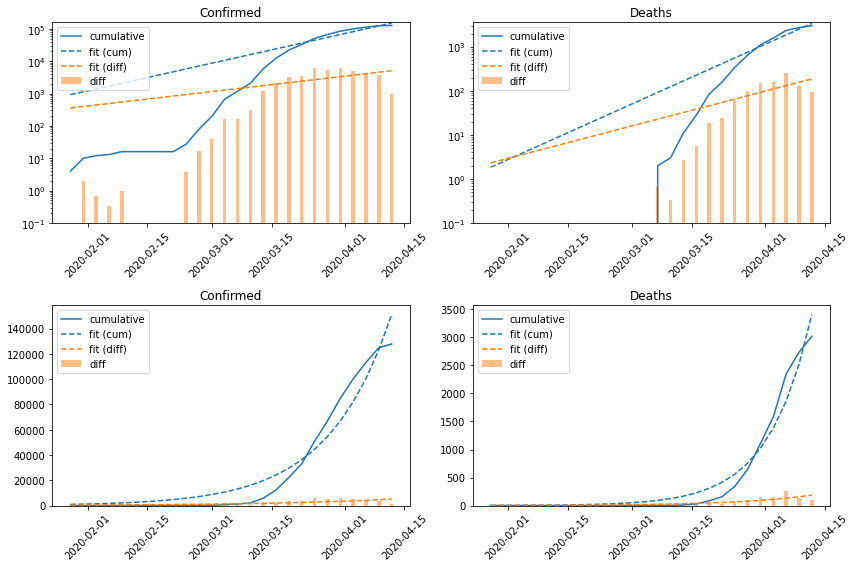

In [15]:
fig, axs = plt.subplots(ncols=len(fields), nrows=2, figsize=(12, 8))

for row, scale in zip(range(2), ["log", "linear"]):
    for col, field in enumerate(fields):
        ax = axs[row][col]

        x, y, x_int, y_int = fit_data[field]
        popt, pcov = fit_results_diff[field]
        popt_int, pcov_int = fit_results_int[field]

        ax.plot(df["date"], y_int, label="cumulative", color="C0")
        ax.plot(df["date"], func(x_int, *popt_int), "--", label="fit (cum)", color="C0")

        ax.bar(df["date"], y, label="diff", color="C1", alpha=0.5)
        ax.plot(df["date"], func(x, *popt), "--", label="fit (diff)", color="C1")

        ax.xaxis.set_tick_params(rotation=45)
        ax.legend()

        #ax.set_yscale("log")
        if scale == "log":
            ax.set_ylim(bottom=1e-1)
        #ax.set_ylim(auto=True)
        #ax.set_yscale("linear")
        ax.set_yscale(scale)

        ax.set_title(field)
fig.tight_layout()

Fit gaussian * exponential (inspired by otmar)

In [16]:
def func2(x, a, c, p1, p2, p3):
    xp = x - c
    xp = a * xp
    return p1 * np.exp(p2 * xp + p3 * xp ** 2)

In [17]:
def fit_and_bootstrap(func, x, y, p0=None, bounds=None, nfits=100):
    popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=p0, bounds=bounds)
    bootstrap_popt = []
    # estimate error by bootstrapping
    failed_fits = 0
    for i in tqdm(range(nfits), desc="Bootstrapping"):
        try:
            pick = np.random.randint(len(x), size=len(x))
            x_bs = x[pick]
            y_bs = y[pick]
            popt_bs, pcov_bs = scipy.optimize.curve_fit(func, x_bs, y_bs, p0=popt, bounds=bounds)
            bootstrap_popt.append(popt_bs)
        except:
            failed_fits += 1
    if failed_fits > 0:
        print(f"Warning! {failed_fits} Failed fits!")
    return popt, pcov, bootstrap_popt


Maximum on 2020-03-29 00:00:00
Fitted between 2020-01-28 00:00:00 and 2020-04-12 00:00:00



Maximum on 2020-04-04 00:00:00
Fitted between 2020-01-28 00:00:00 and 2020-04-12 00:00:00


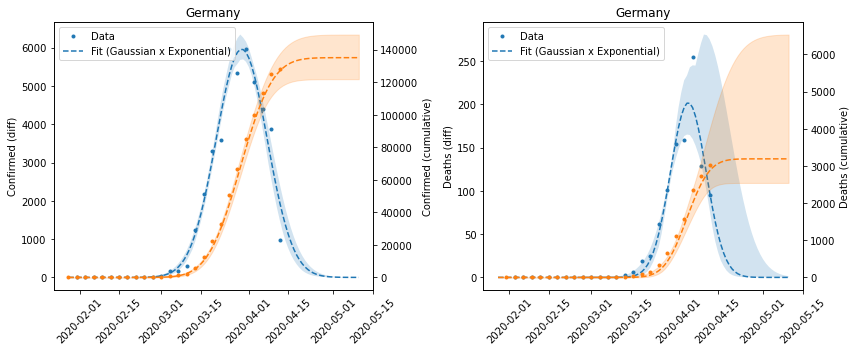

In [18]:
try:
    country = df.iloc[0]["Country_Region"]
except:
    country = ""
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
for field, ax in zip(["Confirmed", "Deaths"], axs):
    x, y, x_int, y_int = fit_data[field]
    goback = None
    start = 0
    if goback is not None:
        x_int_fit = x[:-goback]
        y_int_fit = y[:-goback]
        last_date = df.date.iloc[-(goback-1)]
    else:
        x_int_fit = x
        y_int_fit = y
        last_date = df.date.iloc[-1]
    x_int_fit = x_int_fit[start:]
    y_int_fit = y_int_fit[start:]
    first_date = df.date.iloc[start]
    popt, pcov, bootstrap_opt = fit_and_bootstrap(
        func2, x_int_fit, y_int_fit,
        p0=[1, 30, 1, 1, -0.03],
        bounds=([0, 0, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, 0]),
        nfits=100
    )

    dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-05-10", freq="d")
    days = np.arange(len(dates_extrap))

    alpha = 0.5 * (1 - 0.68)
    low, up = np.quantile(
        np.array([func2(days, *popt) for popt in bootstrap_opt]),
        [alpha, 1 - alpha],
        axis=0
    )

    ax.plot(df.date, df[field+"_diff"], ".", color="C0", label="Data")
    ax.plot(dates_extrap, func2(days, *popt), color="C0", linestyle="--",
            label="Fit (Gaussian x Exponential)")
    ax.fill_between(dates_extrap, low, up, alpha=0.2)
    if goback is not None:
        ax.axvline(last_date, linestyle="--")
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_ylabel(f"{field} (diff)")
    print(f"Maximum on {dates_extrap[np.argmax(func2(days, *popt))]}")
    ax.legend(loc="upper left")
    print(f"Fitted between {first_date} and {last_date}")
    ax2 = ax.twinx()
    ax2.plot(df.date, df[field], ".", color="C1")
    ax2.plot(dates_extrap, np.cumsum(func2(days, *popt)), "--", color="C1")
    ax2.fill_between(dates_extrap, np.cumsum(low), np.cumsum(up), color="C1", alpha=0.2)
    ax2.set_ylabel(f"{field} (cumulative)")
    ax.set_title(country)
fig.tight_layout()
fig.savefig(f"fit_{country}_{date.today().strftime('%Y-%m-%d')}.pdf")

Development of relative increase per day

<ipython-input-19-01ff2b983bdc>:16: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(df["date"], y / y_int, ".", color="C0")
<ipython-input-19-01ff2b983bdc>:19: RuntimeWarning: invalid value encountered in true_divide
  moving_average(y / y_int, n=window),


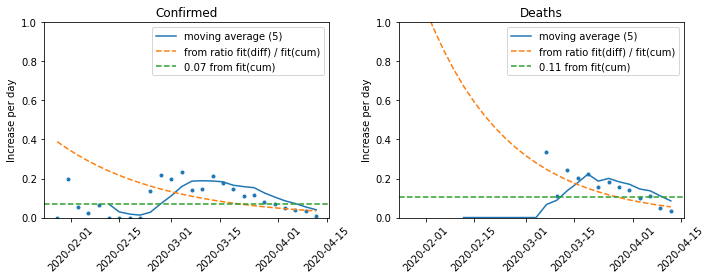

In [19]:
def moving_average(a, n=3) :
    ret = np.cumsum(np.nan_to_num(a, posinf=0, neginf=0), dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n:] / n

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
window = 5

for ax, field in zip(axs, fields):

    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    popt, pcov = fit_results_diff[field]

    inc_from_param = np.exp(popt_int[1]) - 1
    ax.plot(df["date"], y / y_int, ".", color="C0")
    ax.plot(
        df["date"][window:],
        moving_average(y / y_int, n=window),
        color="C0",
        label=f"moving average ({window})"
    )
    ax.plot(
        df["date"],
        func(x, *popt) / func(x_int, *popt_int),
        color="C1",
        linestyle="--",
        label="from ratio fit(diff) / fit(cum)"
    )
    ax.axhline(inc_from_param, linestyle="--", color="C2", label=f"{inc_from_param:.2f} from fit(cum)")
    ax.set_ylabel("Increase per day")
    ax.xaxis.set_tick_params(rotation=45)
    ax.legend()
    ax.set_title(field)
    ax.set_ylim(0, 1)
fig.tight_layout()    
fig.savefig("increase_moving_average.pdf")

### Extrapolation of cumulative cases

Extrapolated until 2020-04-20 00:00:00
Confirmed: 260423.37088372096
Deaths: 7608.71897410996


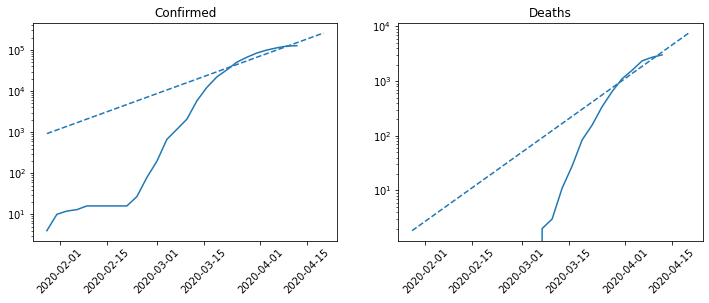

In [20]:
dates_extrap = pd.date_range(start=df.date.iloc[0], end="2020-04-20", freq="d")
days = np.arange(len(dates_extrap))

fig, axs = plt.subplots(ncols=len(fields), figsize=(12, 4))

print(f"Extrapolated until {dates_extrap[-1]}")

for ax, field in zip(axs, fields):
    popt_int, pcov_int = fit_results_int[field]
    x, y, x_int, y_int = fit_data[field]
    pred = func(days, *popt_int)
    ax.plot(df["date"], y_int, label="confirmed", color="C0")
    ax.plot(dates_extrap, pred, "--", color="C0")
    ax.set_yscale("log")
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(field)
    print(f"{field}: {pred[-1]}") # predicted by end of range

### Fitted Parameters and doubling time

In [21]:
fit_results_int

{'Confirmed': (array([ 7.60696445e+00,  6.79836483e-02, -7.05810449e+01]),
  array([[8.90024507e+14, 7.15413399e+04, 1.71456848e+15],
         [7.15413665e+04, 3.69567222e-05, 1.37819384e+05],
         [1.71456848e+15, 1.37819333e+05, 3.30299339e+15]])),
 'Deaths': (array([ 5.89189851,  0.10036431, 11.62530511]),
  array([[9.01475863e+13, 2.83730647e+04, 1.53133906e+14],
         [2.83730670e+04, 6.15538849e-05, 4.81974236e+04],
         [1.53133906e+14, 4.81974197e+04, 2.60128909e+14]]))}

In [22]:
fit_results_diff

{'Confirmed': (array([ 1.21969429e+01,  3.53664069e-02, -9.56045515e+01]),
  array([[1.08228733e+16, 2.94258928e+04, 2.49555587e+16],
         [2.94258211e+04, 1.04015817e-04, 6.78510051e+04],
         [2.49555587e+16, 6.78511700e+04, 5.75429363e+16]])),
 'Deaths': (array([ 6.52441256,  0.05852488, 17.69822686]),
  array([[6.45830753e+15, 3.63144905e+05, 1.68267037e+16],
         [3.63144923e+05, 2.12155149e-04, 9.46150840e+05],
         [1.68267037e+16, 9.46150790e+05, 4.38408914e+16]]))}

In [23]:
np.log(2) / fit_results_int["Confirmed"][0][1]

10.195792639792401

In [24]:
np.log(2) / fit_results_int["Deaths"][0][1]

6.906311592233694

### Death rate

In [25]:
df["death_rate"] = df["Deaths"] / df["Confirmed"]

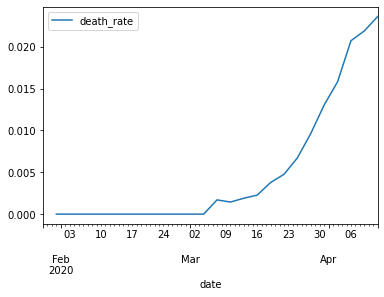

In [26]:
ax = df.plot(x="date", y="death_rate")
fig = ax.get_figure()